In [1]:
!pip install kaggle

In [0]:
!mkdir ~/.kaggle/
!mv kaggle.json ~/.kaggle/kaggle.json

In [3]:
!ls ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

kaggle.json


In [4]:
!kaggle datasets list

ref                                                       title                                               size  lastUpdated          downloadCount  
--------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
tristan581/17k-apple-app-store-strategy-games             17K Mobile Strategy Games                            8MB  2019-08-26 08:22:16           1925  
dgomonov/new-york-city-airbnb-open-data                   New York City Airbnb Open Data                       2MB  2019-08-12 16:24:45          30821  
gustavomodelli/forest-fires-in-brazil                     Forest Fires in Brazil                              31KB  2019-08-24 16:09:16           3193  
shuyangli94/food-com-recipes-and-user-interactions        Food.com Recipes and Interactions                  261MB  2019-10-12 06:30:37            973  
rajeevw/ufcdata                                           UFC-Fight historical dat

In [5]:
!kaggle datasets download fpeccia/weed-detection-in-soybean-crops

100% 2.36G/2.37G [00:30<00:00, 120MB/s] 
100% 2.37G/2.37G [00:30<00:00, 83.1MB/s]


In [6]:
!unzip weed-detection-in-soybean-crops.zip -d data

Archive:  weed-detection-in-soybean-crops.zip
  inflating: data/dataset/broadleaf/1.tif  
  inflating: data/dataset/broadleaf/10.tif  
  inflating: data/dataset/broadleaf/100.tif  
  inflating: data/dataset/broadleaf/1000.tif  
  inflating: data/dataset/broadleaf/1001.tif  
  inflating: data/dataset/broadleaf/1002.tif  
  inflating: data/dataset/broadleaf/1003.tif  
  inflating: data/dataset/broadleaf/1004.tif  
  inflating: data/dataset/broadleaf/1005.tif  
  inflating: data/dataset/broadleaf/1006.tif  
  inflating: data/dataset/broadleaf/1007.tif  
  inflating: data/dataset/broadleaf/1008.tif  
  inflating: data/dataset/broadleaf/1009.tif  
  inflating: data/dataset/broadleaf/101.tif  
  inflating: data/dataset/broadleaf/1010.tif  
  inflating: data/dataset/broadleaf/1011.tif  
  inflating: data/dataset/broadleaf/1012.tif  
  inflating: data/dataset/broadleaf/1013.tif  
  inflating: data/dataset/broadleaf/1014.tif  
  inflating: data/dataset/broadleaf/1015.tif  
  inflating: data/dat

In [7]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.backend import clear_session
from keras.optimizers import SGD
from pathlib import Path
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, AveragePooling2D
from keras import initializers, regularizers

Using TensorFlow backend.


In [0]:
# Config
height = 224
width = height

In [9]:
conv_base = MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(height, width, 3)
)

# First time run, no unlocking
conv_base.trainable = False












9412608/9406464 [==============================] - 0s 0us/step


In [14]:
# Let's see it
print('Summary')
print(conv_base.summary())

Summary
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________

In [10]:
num_classes = 4
# Let's construct that top layer replacement
x = conv_base.output
x = AveragePooling2D(pool_size=(7, 7))(x)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(.0005))(x)
x = Dropout(0.5)(x)
# Essential to have another layer for better accuracy
x = Dense(128,activation='relu', kernel_initializer=initializers.he_normal(seed=None))(x)
x = Dropout(0.25)(x)
predictions = Dense(num_classes,  kernel_initializer="glorot_uniform", activation='softmax')(x)

print('Stacking New Layers')
model = Model(inputs = conv_base.input, outputs=predictions)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Stacking New Layers


In [0]:
from keras.callbacks import LearningRateScheduler

# Slow down training deeper into dataset
def schedule(epoch):
    if epoch < 3:
        # Warmup model first
        return .0000032
    elif epoch < 12:
        return .01
    elif epoch < 15:
        return .008
    elif epoch < 18:
        return .0035
    elif epoch < 20:
        return .00058
    elif epoch < 80:
        return .000016
    elif epoch < 95:
        return .0000032        
    else:
        return .0000009    
      
lr_scheduler = LearningRateScheduler(schedule)


In [12]:
print('Compile model')
opt = SGD(momentum=.9)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

Compile model




In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=20,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data should not be modified
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

In [0]:
train_dir = os.path.join('./data', 'dataset', 'dataset')
test_dir = os.path.join('./data', 'dataset', 'dataset')

In [15]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    class_mode='categorical',
    batch_size=64
)

validation_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    class_mode='categorical',
    batch_size=64
)

Found 15336 images belonging to 4 classes.
Found 15336 images belonging to 4 classes.


In [16]:
history = model.fit_generator(
    train_generator,
    callbacks=[lr_scheduler],
    epochs=10,
    steps_per_epoch=10,
    shuffle=True,
    workers=4,
#     use_multiprocessing=False,
    validation_data=validation_generator,
    validation_steps=5
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
10/10 [==============================] - 26s 3s/step - loss: 1.9418 - acc: 0.2594 - val_loss: 2.3548 - val_acc: 0.0719
Epoch 2/10
10/10 [==============================] - 9s 872ms/step - loss: 2.0335 - acc: 0.2703 - val_loss: 1.7804 - val_acc: 0.1625
Epoch 3/10
10/10 [==============================] - 9s 873ms/step - loss: 1.9207 - acc: 0.2906 - val_loss: 1.7197 - val_acc: 0.2531
Epoch 4/10
10/10 [==============================] - 9s 875ms/step - loss: 1.2868 - acc: 0.5687 - val_loss: 2.0430 - val_acc: 0.2719
Epoch 5/10
10/10 [==============================] - 9s 880ms/step - loss: 0.5239 - acc: 0.9047 - val_loss: 3.5467 - val_acc: 0.3094
Epoch 6/10
10/10 [==============================] - 9s 871ms/step - loss: 0.3730 - acc: 0.9719 - val_loss: 5.0415 - val_acc: 0.3625
Epoch 7/10
10/10 [==============================] - 10s 963ms/step - loss: 0.4373 - acc: 0.9521 - val_loss: 5.3307

In [25]:
# Save it for later
print('Saving Model')
model.save("soybean.h5")

Saving Model


## Download model

In [0]:
from google.colab import files
files.download('soybean.h5') 

# Now check an entire folder!

Homework asked to check at least 2 images, this checks hundreds

In [0]:
from keras.preprocessing import image
import numpy as np

In [41]:
for f in sorted(Path("./data/dataset/grass").glob("**/*.tif")):
    # Load an image file to test
    image_to_test = image.load_img(
        str(f),
        target_size=(224, 224)
    )

    # Convert the image data to a numpy array
    # suitable for Keras
    image_to_test = image.img_to_array(image_to_test)
    # normalize to a 0 to 1 value
    image_to_test /= 255

    # Add a fourth dimension to the image since
    # Keras expects a list of images
    list_of_images = np.expand_dims(
        image_to_test,
        axis=0
    )
    # Make a prediction using the model
    results = model.predict(list_of_images)

    # Since we only passed in one test image,
    # we can just check the first result directly.
    image_likelihood = results[0]
    
    print(np.argmax(results, axis=1))

    

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


Processed 1000 - Current Folder: broadleaf
Processed 2000 - Current Folder: grass
Processed 3000 - Current Folder: grass
Processed 4000 - Current Folder: grass
Processed 5000 - Current Folder: soil
Processed 6000 - Current Folder: soil
Processed 7000 - Current Folder: soil
Processed 8000 - Current Folder: soybean
Processed 9000 - Current Folder: soybean
Processed 10000 - Current Folder: soybean
Processed 11000 - Current Folder: soybean
Processed 12000 - Current Folder: soybean
Processed 13000 - Current Folder: soybean
Processed 14000 - Current Folder: soybean
Processed 15000 - Current Folder: soybean
Normalized confusion matrix
[[8.30e-01 1.70e-01 0.00e+00 0.00e+00]
 [0.00e+00 1.00e+00 0.00e+00 0.00e+00]
 [4.92e-02 7.57e-01 1.94e-01 3.08e-04]
 [3.74e-02 9.54e-01 0.00e+00 8.41e-03]]


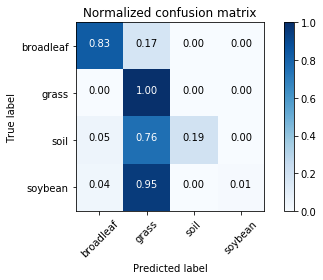

In [19]:
import itertools
import matplotlib.pyplot as plt
import os
import numpy as np
from keras.preprocessing import image
from pathlib import Path
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

image_size = 224
x_test = []
y_test = []
file_count = 0
update_frequency = 1000

class_names = ['broadleaf', 'grass', 'soil', 'soybean']

for image_file in sorted(Path("./data/dataset/dataset").glob("**/*.tif")):
    file_count += 1
    # Load the current image file
    image_data = image.load_img(image_file, target_size=(image_size, image_size))

    # Convert the loaded image file to a numpy array
    image_array = image.img_to_array(image_data)
    image_array /= 255

    # Add to list of test images
    x_test.append(image_array)
    # Now add answer derived from folder
    path_name = os.path.dirname(image_file)
    folder_name = os.path.basename(path_name)
    y_test.append(class_names.index(folder_name))

    if file_count % update_frequency == 0:
        print("Processed " + str(file_count) + " - Current Folder: " + folder_name)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.get_cmap('Blues')):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

x_test = np.array(x_test)
predictions = model.predict(x_test)
y_pred = np.argmax(predictions, axis=1)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()